<a href="https://colab.research.google.com/github/puneet-08/projects/blob/main/NMT_%2B_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation with Attention

In this notebook we are going to implement a Seq2Seq machine translation model with attention (Bahdanau’s Attention) for translating spanish sentences to english.

Neural Machine Translation is the task of converting a sequence of words from a source language, like English, to a sequence of words to a target language like German or Spanish using deep neural networks.


In [ ]:
#Importing required libraries
import numpy as np
import spacy
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Bidirectional, TimeDistributed,InputLayer, Lambda
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization, Dropout,Concatenate, AdditiveAttention
import time
import os
import zipfile

### Dataset

We are going to use 'spanish to english' dataset provided by  [ http://www.manythings.org/anki/ ](http://www.manythings.org/anki/). This dataset contains pairs of text in both source and target languages.

In [ ]:
#Extracting the file
zipfile.ZipFile('/content/spa-eng.zip', 'r').extractall()

In [ ]:
#Loading the file as a dataframe
lines = pd.read_table('/content/spa.txt', names = ['english', 'spanish', 'comments'])
lines.head()

,english,spanish,comments
0,Go.,Ve.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Vete.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Vaya.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Váyase.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Hola.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


**Data Preprocessing**

We need to do some preprocessing to make it more suitable for our model - 

*   Append [sos] (start of sentence) token in the begining and [eos] (end of sentence) token in the end of each sentence of the target language.
*   Append [eos] (end of sentence) token in the end of each sentence of the source language.
*   We need to reverse each of the sentence in the source language.

Reason for both of the above will be discussed in more detail later in the notebook.

In this notebook we are going to consider 'spanish' as 'source language' and 'english' as target language.

We also need to tokenize the sentences and make them of same length.

In [ ]:
#Data preprocessing

lines['english'] = lines['english'].apply(lambda x : '[sos] ' + x + ' [eos]')
lines['spanish'] = lines['spanish'].apply(lambda x : x + ' [eos]')
lines['spanish_rev'] = lines['spanish'].apply(lambda x: ' '.join(reversed(x.split(" "))))
lines.tail()

,english,spanish,comments,spanish_rev
138432,[sos] A carbon footprint is the amount of carb...,Una huella de carbono es la cantidad de contam...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...,[eos] climático. cambio del acerca preocupados...
138433,[sos] Since there are usually multiple website...,Como suele haber varias páginas web sobre cual...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...,[eos] irritante. menos algo encontrar espero y...
138434,[sos] If you want to sound like a native speak...,"Si quieres sonar como un hablante nativo, debe...",CC-BY 2.0 (France) Attribution: tatoeba.org #9...,[eos] esperado. tiempo el en y correctamente t...
138435,[sos] It may be impossible to get a completely...,Puede que sea imposible obtener un corpus comp...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...,[eos] errores. los minimizar de capaces ser po...
138436,"[sos] One day, I woke up to find that God had ...","Un día, me desperté y vi que Dios me había pue...",CC-BY 2.0 (France) Attribution: tatoeba.org #1...,[eos] barba. tengo eso Por suya. la con salier...


In [ ]:
#Shuffling the dataset
lines = lines.iloc[np.random.permutation(len(lines))]

In [ ]:
lines.head()

,english,spanish,comments,spanish_rev
35481,[sos] They took it by force. [eos],Ellos se lo tomaron por la fuerza. [eos],CC-BY 2.0 (France) Attribution: tatoeba.org #1...,[eos] fuerza. la por tomaron lo se Ellos
84734,[sos] You're just stating the obvious. [eos],Estás simplemente afirmando lo obvio. [eos],CC-BY 2.0 (France) Attribution: tatoeba.org #2...,[eos] obvio. lo afirmando simplemente Estás
71841,[sos] He is not a man to be trusted. [eos],No es un hombre en el que se pueda confiar. [eos],CC-BY 2.0 (France) Attribution: tatoeba.org #2...,[eos] confiar. pueda se que el en hombre un es No
94705,[sos] My grandfather died five years ago. [eos],Mi abuelo murió hace cinco años. [eos],CC-BY 2.0 (France) Attribution: tatoeba.org #2...,[eos] años. cinco hace murió abuelo Mi
107220,"[sos] My father does play golf, but not well. ...","Mi padre sí que juega al golf, pero no lo hace...",CC-BY 2.0 (France) Attribution: tatoeba.org #3...,"[eos] bien. hace lo no pero golf, al juega que..."


In [ ]:
#We are going to use 60,000 examples for training and 10,000 examples for validation

eng_train = lines['english'].values[:60000].tolist() #english trianing data
eng_val = lines['english'].values[60000:70000].tolist() #english validation data

spa_train = lines['spanish_rev'].values[:60000].tolist() #spanish training data in reverse order
spa_fwd = lines['spanish'].values[:60000].tolist() #spanish training data in normal order
spa_val = lines['spanish_rev'].values[60000:70000].tolist() #spanish validation data in reverse order
spa_val_fwd = lines['spanish'].values[60000:70000].tolist() #spanish validaton data in normal order

In [ ]:
#Printing a few lines and statistics to ensure our dataset is as per our intentions
spa_fwd[0], spa_train[0], eng_train[0], len(eng_train), len(eng_val), len(spa_train), len(spa_val)

('Ellos se lo tomaron por la fuerza. [eos]',
 '[eos] fuerza. la por tomaron lo se Ellos',
 '[sos] They took it by force. [eos]',
 60000,
 10000,
 60000,
 10000)

Now we are going to tokenize both our source sentences and the target sentences. Also we need to ensure that all our sentences of both source and target are of same length. In order to do this we set 'output sequence length'-

*   If the sentence is bigger than 'output sequence length', it is cropped. Otherwise,
*   if it is smaller than 'output sequence length', it is padded with 0s. 

In [ ]:
#Initializing the tokeninzers
vectorize_eng = TextVectorization(max_tokens = 15000, output_mode='int', output_sequence_length=21)
vectorize_spa = TextVectorization(max_tokens = 15000, output_mode='int', output_sequence_length=20)

#Creating the vocabulary on the training text
vectorize_eng.adapt(eng_train)
vectorize_spa.adapt(spa_train)

In [ ]:
#Creating numerical index for source and target language
eng_dict ={k:v for k,v in enumerate(vectorize_eng.get_vocabulary())}
spa_dict ={k:v for k,v in enumerate(vectorize_spa.get_vocabulary())}

In [ ]:
#Tokenizing the datasets

inputs_encoder = vectorize_spa(spa_train)
inputs_decoder = vectorize_eng(eng_train)

inputs_encoder.shape, inputs_decoder.shape

(TensorShape([60000, 20]), TensorShape([60000, 21]))

In [ ]:
#setting the batch size
batch_size = 64

#shuffles the data in the batch
dataset=tf.data.Dataset.from_tensor_slices((inputs_encoder, inputs_decoder)).shuffle(batch_size)

#extracting a single bactch 
dataset = dataset.batch(batch_size, drop_remainder=True)

source_batch, target_batch =next(iter(dataset))

#checking the shape of the batches
print(source_batch.shape, target_batch.shape)

(64, 20) (64, 21)


## Model Architecture

**Brief Introduction**

Sequence-to-sequence, or "Seq2Seq",  model architectures employs encoder and decoder consisting of Recurrent Neural Networks.

Our NMT model has three parts-

1.   **Encoder** - Encoder encodes a source sentence to a vector which contains all the information of the sentence.
2. **Attention** - Attention vector provides the context to the decoder. Usually the orderings of words in source sentence and target setence can be at different places, so the task of attention layer is to help decoder attend the most important word/phrase of the source language while trying to predict the sequential word in the target language.
3.   **Decoder** - Decoder usually takes in the output of encoder and an attention vector as inputs and decodes the source sentence to the target language.



### Encoder

Encoder's job is to read input sequence and generate a fixed-dimensional  encoder output vector E. Usually recurrent neural networks - such as LSTM are used for this purpose. It is quite difficult to compress all the information from a sentence to a fixed length vector. Therefore, it becomes more reasonable to stack muliple LSTMs as they are better at learning long range language dependencies. The final layer’s LSTM hidden state will be used as encoder output vector E.

It is quite normal to feed **'reverse sequences'** to encoders. Idea behind this methodology is that - the last thing that encoder processes will be the first thing input into the decoder and therefore the first thing that model needs to output. This strategy makes it easier for the decoder to "get started" on the output,
which then gives the decoder an easier time generating a proper output sentence.In the context of translation, we’re allowing the network to translate the first few words of the input as soon as it sees them; once it has the first few words translated correctly, it’s much easier to go on to construct a correct sentence than it is to do so from scratch.

The figure below shows encoder and decoder stack without the attention layer.

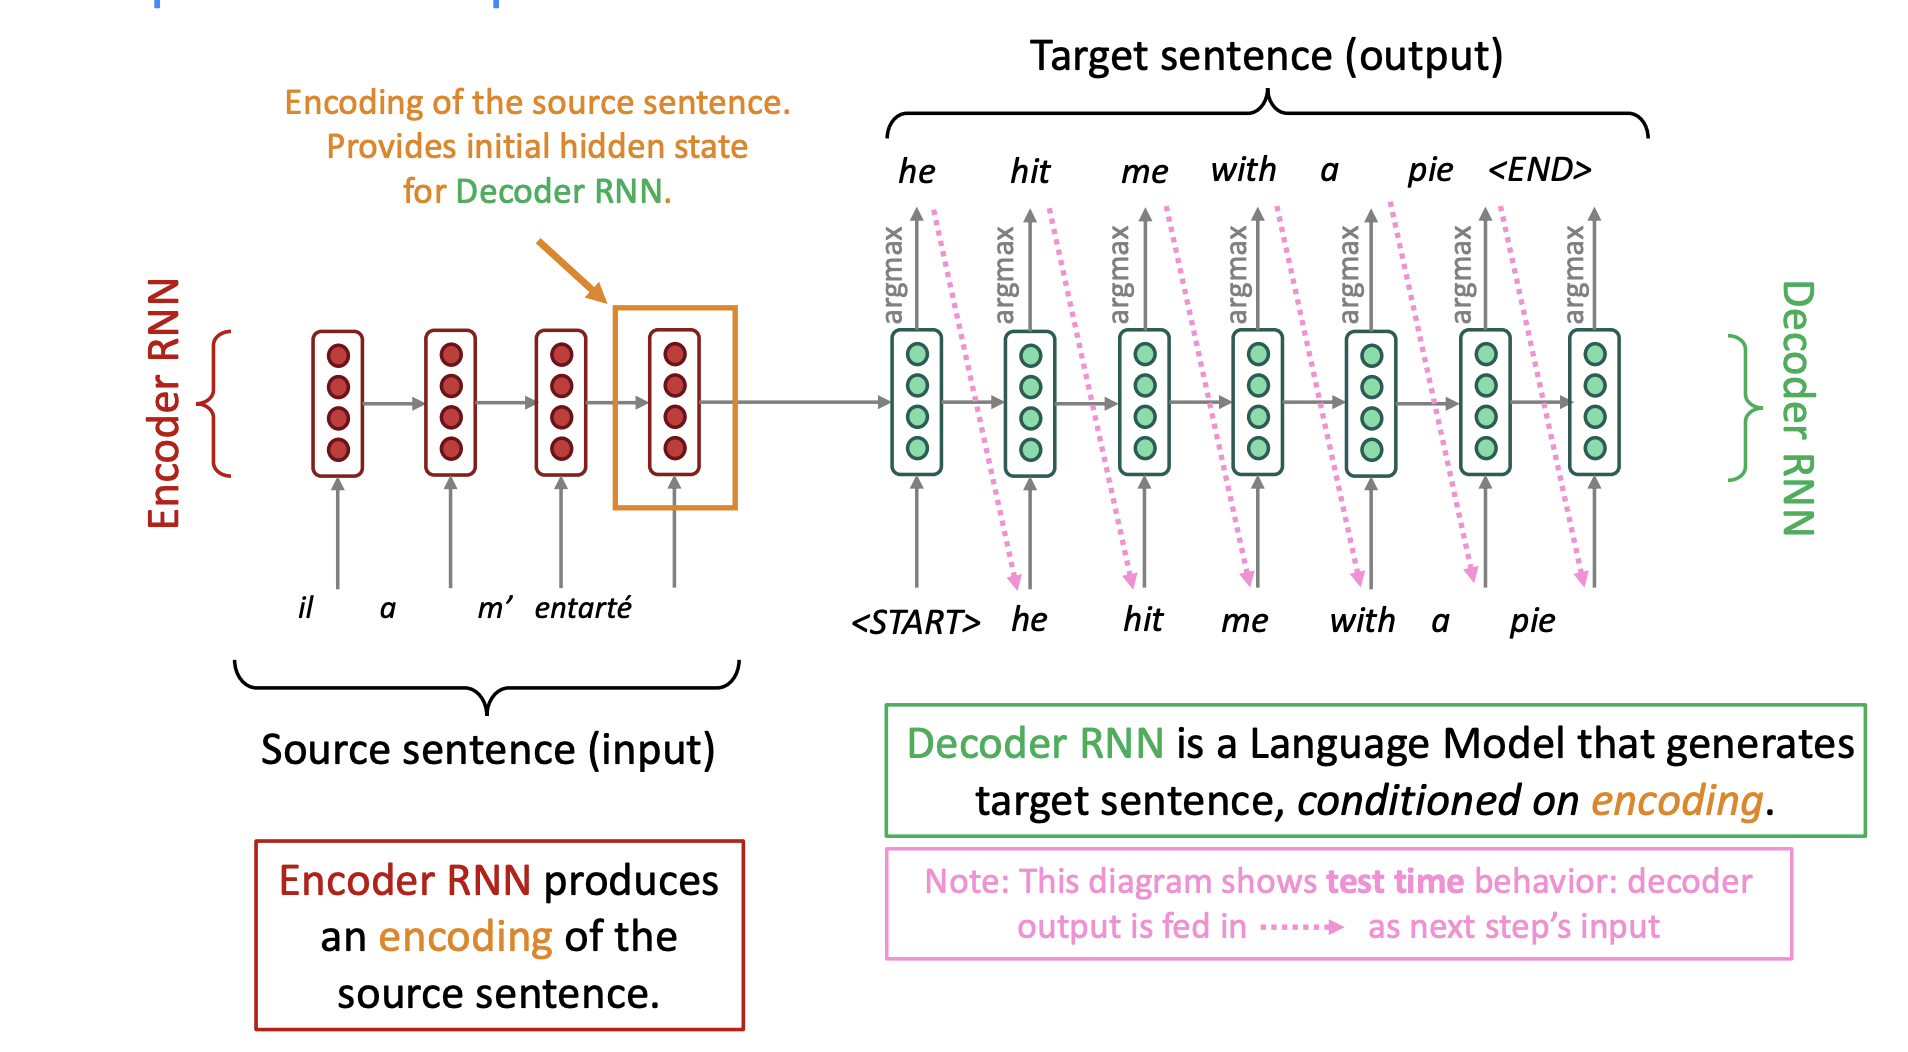

In our encoder model we are using a single layer BiDirectional LSTM. We initialize the hidden state of LSTM with zeros.

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, encoder_units, batch_size, enc_dropout =0.5):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.encoder_units = encoder_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm_layer = Bidirectional(LSTM(encoder_units, return_sequences=True, return_state = True))
    self.dropout = Dropout(enc_dropout)

  def call(self, x, hidden):
    
    x = self.embedding(x) #x output == (batch_size, input_size/sentence_size = 20, encoding_dim)
    x = self.dropout(x)
    output, m_1, c_1, m_2, c_2 = self.lstm_layer(x, initial_state = hidden)
    m_state = tf.concat([m_1,m_2], axis=-1)
    c_state = tf.concat([c_1,c_2], axis=-1)
    state = [m_state, c_state]
    return output, state

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_size, self.encoder_units)), tf.zeros((self.batch_size, self.encoder_units)),
            tf.zeros((self.batch_size, self.encoder_units)), tf.zeros((self.batch_size, self.encoder_units))]

In [ ]:
#Testing Encoder Stack

encoder = Encoder(15000, 300, 512, 64)
example_input_batch = tf.ones((64,20))

#Sample input
sample_hidden = encoder.initialize_hidden_state()

sample_output, state = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder m vector shape: (batch size, units) {}'.format(state[0].shape))
print ('Encoder c vector shape: (batch size, units) {}'.format(state[1].shape))

Encoder output shape: (batch size, sequence length, units) (64, 20, 1024)
Encoder m vector shape: (batch size, units) (64, 1024)
Encoder c vector shape: (batch size, units) (64, 1024)


### Attention

While translating a certain word in target language, some words in source language have more context than the others. In order to provide this context to the decoder, we use methodology of 'attention'.

While predicting a word at time step 't'; we use - encoder output vector E from encoder and word predicted at 't-1' step by the decoder to calculate context vector C. This context vector is nothing but a encoder output vector E, weighted by amount of attention. Context vector C is calculated at each time step so that decoder knows what to attend to and what to ignore.

There are many Attention architectures but we are going to employ [Bahdanau’s attention](https://arxiv.org/pdf/1409.0473.pdf) in this notebook. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).


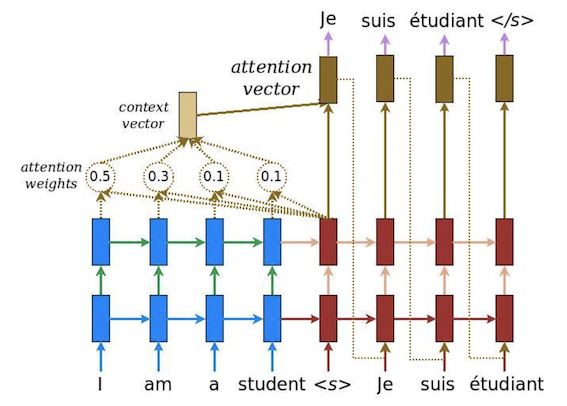

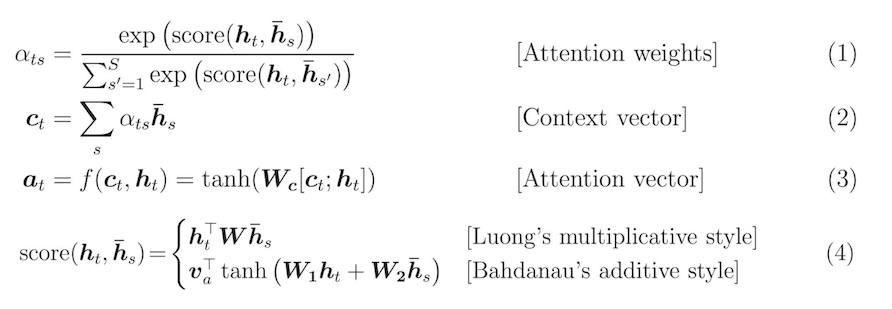

Let's decide on notation before writing the simplified form:

*   FC = Fully connected (dense) layer
*   E = Encoder output
*   H = hidden state
*   X = input to the decoder

And the pseudo-code:

*   score = FC(tanh(FC(E) + FC(H)))
*   attention weights = softmax(score, axis = 1). 
*   context vector = sum(attention weights * EO, axis = 1). 


In [ ]:
class Attention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(Attention, self).__init__()
    self.W1 = Dense(units) #encoder output
    self.W2 = Dense(units) #decoder output
    self.V = Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query,1)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))) #score == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)   # attention_weights shape == (batch_size, max_length, 1)
    context_vector = values * attention_weights
    context_vector = tf.reduce_sum(context_vector, axis=1) 
    return context_vector, attention_weights

In [ ]:
#Testing Attention Layer

sample_hidden = state[0] #output from a single lstm unit of decoder
attention_layer = Attention(10)
context_vector, attention_weights = attention_layer(sample_hidden, sample_output)

print("Context vector shape: (batch size, units) {}".format(context_vector.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Context vector shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 20, 1)


### Decoder

Decoder's job is to generate outputs in the target language given a encoder ouput vector E from the encoder. We want our decoder to be a language model which is "aware" of the words that it’s generated so far and of the input and use it as context to predict the next word. Enocder output E is used to calculate context vector C using attention. We can use the stacked LSTM structure like we used in the encoder. Hidden state of the decoder is initialized with the encoder output E. Along with this we need to feed a 'word vector' to the decoder at each timestep. Decoder combines context vector (calculated from attention layer) and word vector to predict the next word. Decoder stops outputing words after [EOS] token is generated by it.

Decoder psuedo code -

*   hidden state of encoder and encoder output are fed to decoder to calculate context_vector and attention weights.
*   embedding output = The input to the decoder X is passed through an embedding layer.
*   merged vector = concat(embedding output, context vector)
*   This merged vector is then given to the LSTM which predicts the next word.

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, decoder_units, batch_size, dec_dropout = 0.5):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.decoder_units = decoder_units
    self.embedding = Embedding(vocab_size, embedding_dim)
    self.lstm_layer = LSTM(self.decoder_units, return_sequences=True, return_state = True) #return_sequences = True?
    self.fc = Dense(vocab_size)
    self.attention = Attention(self.decoder_units)
    self.dropout = Dropout(dec_dropout)

  def call(self, x, hidden, enc_output):
    context_vector, attention_weights = self.attention(hidden[0], enc_output) #hidden[0] only memory state is sent to attention and not the cell state
    x = self.embedding(x) # x shape after passing through embedding == (batch_size, 1, embedding_dim) 
    x = self.dropout(x)
    x = tf.concat([tf.expand_dims(context_vector, axis=1),x], axis=-1)  # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    output, m_state, c_state = self.lstm_layer(x, initial_state = hidden) #output_shape = (batch_size, 1 ,hidden_size)
    output = tf.reshape(output, (-1, output.shape[-1]))
    state =[m_state, c_state]
    x = self.fc(output) #shape=(batch_size, vocab)

    return x, state, attention_weights


In [ ]:
## Test Decoder Stack

decoder= Decoder(15000, 300, 1024, 64)

sample_decoder_output, state, attention_weights = decoder(tf.random.uniform((64,1)), state, sample_output) #why 64,1 why not 64,20
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))
print ('State shape: (batch_size, decoder_units) {}'.format(state[0].shape))
print ('Attention weights shape: (batch_size, sequence_length, 1) {}'.format(attention_weights.shape))


Decoder output shape: (batch_size, vocab size) (64, 15000)
State shape: (batch_size, decoder_units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 20, 1)


### Training the Model


**Defining the Loss function**

As our sentences are padded with tokens; we need to ensure that while calcuating the loss, our model ignores all the predictions for the masked tokens. Therefore we are going to write a custom loss function which is similar to cross entropy but also ignores the masks.

In [ ]:
optimizer = Adam() #using adam optimizer
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = real!=0
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

**Defining Model Hyperparameters**

In [ ]:
#Model Hyperparameters

vocab_size = 15000
embedding_dim = 300
encoder_units = 512
decoder_units = 1024
batch_size = 64

#Initializing Encoder and Decoder architecture
encoder = Encoder(vocab_size, embedding_dim, encoder_units, batch_size)
decoder = Decoder(vocab_size, embedding_dim, decoder_units, batch_size)

steps_per_epoch = (inputs_encoder.shape[0])//batch_size

**Model Training Methodology**

Both the encoder and decoder are trained at the same time. During backpropagation, the encoder’s LSTM weights are updated so that it learns a better vector space representation for sentences, while the decoder’s LSTM weights are trained to allow it to generate grammatically correct sentences that are relevant to the encoder output vector.

During a single training step encoder is fed with a source language sentence and decoder is fed with corresponding target langauage sentence, both token by token. 

The source language sentences are appended with [eos] (end of sentence) token at the end of each sentence. Since all of the punctuation is stripped from both source as well as target sentences, this token does the job of 'fullstop'. Whenever the encoder encounters [eos] it is trained to know that the sentence is finished.

The target language sentences are appended with [sos] (start of sentence) token in the begining and [eos] (end of sentence) token at the end. 

[sos] token forces decoder to know that it needs to start predicting and [eos] forces decoder to stop predicting.

At starting we feed [sos] to decoder. It combines this token and encoder output vector E to predict first word. We calculate the cross entropy loss metric of predicted word and actual word. At next time step we feed in the correct word regardless of any prediction- this is called **teacher forcing**. We continue this until [eos] is input to decoder. This forces decoder to learn to stop.

Let's code this now -

In [ ]:
#Training -

@tf.function
def train_step(input, target, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        #create encoder
        enc_output, enc_hidden = encoder(input, enc_hidden)
        dec_hidden = enc_hidden

        # Teacher forcing - feeding the target word as the next input
        for t in range(0, target.shape[1]-1):
          dec_input = tf.expand_dims(target[:,t],axis =-1)

          # passing enc_output to the decoder
          predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

          # calculate loss based on predictions  
          loss += loss_function(tf.expand_dims(target[:,t+1],axis=-1), predictions)
    
    batch_loss = (loss / (int(target.shape[1])-1))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss

In [ ]:
epochs=15
for epoch in range(epochs):
  start = time.time()
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  # train the model using data in bataches 
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss
    if batch % 100 == 0:
        print('Epoch {} Batch {} Loss {}'.format(epoch + 1, batch, batch_loss.numpy()))

  print('Epoch {} Loss {}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for {} epoch {} sec\n'.format(epoch+1, time.time() - start))

Epoch 1 Batch 0 Loss 3.3203766345977783
Epoch 1 Batch 100 Loss 1.8001495599746704
Epoch 1 Batch 200 Loss 1.5712051391601562
Epoch 1 Batch 300 Loss 1.6403206586837769
Epoch 1 Batch 400 Loss 1.3215217590332031
Epoch 1 Batch 500 Loss 1.4173980951309204
Epoch 1 Batch 600 Loss 1.2536576986312866
Epoch 1 Batch 700 Loss 1.1500276327133179
Epoch 1 Batch 800 Loss 1.074793815612793
Epoch 1 Batch 900 Loss 1.0954474210739136
Epoch 1 Loss 1.3849616050720215
Time taken for 1 epoch 464.8400785923004 sec

Epoch 2 Batch 0 Loss 0.9492301344871521
Epoch 2 Batch 100 Loss 1.1078366041183472
Epoch 2 Batch 200 Loss 0.9447927474975586
Epoch 2 Batch 300 Loss 0.9904775023460388
Epoch 2 Batch 400 Loss 0.8145954012870789
Epoch 2 Batch 500 Loss 0.8589162826538086
Epoch 2 Batch 600 Loss 0.7775675654411316
Epoch 2 Batch 700 Loss 0.6637332439422607
Epoch 2 Batch 800 Loss 0.71165531873703
Epoch 2 Batch 900 Loss 0.7509482502937317
Epoch 2 Loss 0.8682975172996521
Time taken for 2 epoch 421.1483459472656 sec

Epoch 3 Bat

### Translating Sentences using the Model

During prediction, instead of using teacher-forcing; at time-step 't' we input the word predicted at time-step 't-1'. We keep on repeating this until the model predicts [eos] or we reach a predefined maximum length for the traget sentence.

In [ ]:
def decode(sentence):
  attention_plot = np.zeros((20,20))
  
  #preprocessing input sentence
  input_sentence = ' '.join(reversed(sentence.split(" ")))
  tokenized_input_sentence = vectorize_spa([input_sentence])

  decoded_sentence = 'sos'

  #initializing encoder hidden state and then encoder
  enc_hidden = [tf.zeros((1, 512)), tf.zeros((1, 512)), tf.zeros((1, 512)), tf.zeros((1, 512))]
  enc_out, enc_hidden = encoder(tokenized_input_sentence, enc_hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims(vectorize_eng([decoded_sentence]), axis = 0)[:,:,0]
  

  for t in range(tokenized_input_sentence.shape[-1]):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    attention_plot[t+1,:] = attention_weights[0].numpy().reshape(-1,)
    dec_input = tf.expand_dims([np.argmax(predictions)],axis=0) #feeding in the predction as the next decoder input
    decoded_sentence =decoded_sentence+" "+ eng_dict[np.argmax(predictions)]
    if eng_dict[np.argmax(predictions)] == 'eos':
      break
  attention_plot = attention_plot[:len(decoded_sentence.split()), :len(sentence.split())]
  attention_plot = attention_plot[:,::-1]

  return decoded_sentence, sentence, attention_plot 

In [ ]:
#checking our translation on a random training sentence
i = np.random.randint(0, 60000)
print(i)
dec, sentence, attn = decode(spa_fwd[i])
print('Sentence    :',spa_fwd[i])
print('Translation :',eng_train[i])
print('\n')
print('Predicted Translation:', dec)

43693
Sentence    : Quiero mi desayuno. [eos]
Translation : [sos] I want to have my breakfast. [eos]


Predicted Translation: sos i want to have my breakfast eos


**Attention Graph**

We are going to plot attention weights. This plot will show us which all words in the source langague does our model put most attention to while translating a particualar word of the target sentence.  

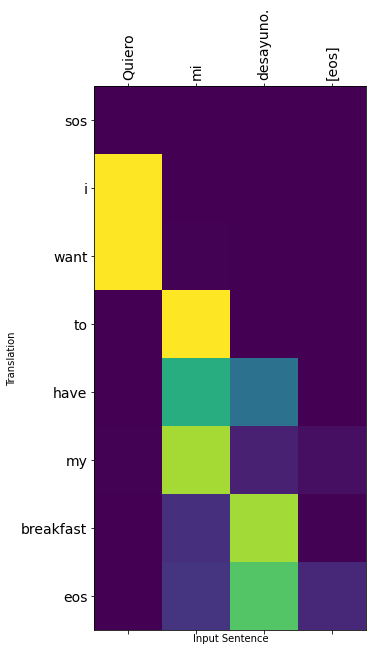

In [ ]:
#Attention Graph

predicted_sentence = dec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')

fontdict = {'fontsize': 14}

ax.set_xticklabels(['']+ sentence.split() , fontdict=fontdict, rotation=90)
ax.set_yticklabels(['']+predicted_sentence.split(), fontdict=fontdict)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Input Sentence')
ax.set_ylabel('Translation')
plt.show()

The above sentence serves as a good example. The spanish sentence contains only three words, and translated english contains six words. The graph shows how the model considers single or multiple spanish words while transtaing each of the english word.

Creating a couple of more graphs-

7011
Sentence    : En muchas partes, la naturaleza está amenazada por actividad humana. [eos]
Translation : [sos] In many places, nature is threatened by human activity. [eos]


Predicted Translation: sos in many places nature is threatened by human activity eos


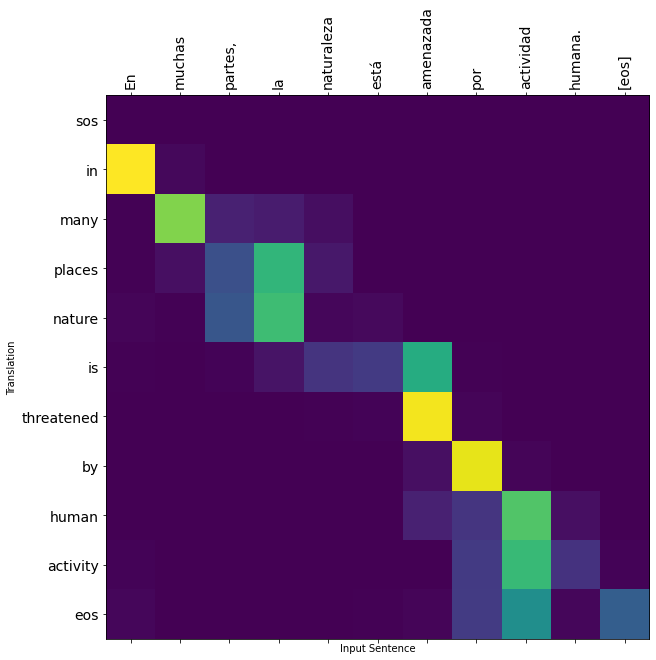

In [ ]:
i = np.random.randint(0, 60000)
print(i)
dec, sentence, attn = decode(spa_fwd[i])
print('Sentence    :',spa_fwd[i])
print('Translation :',eng_train[i])
print('\n')
print('Predicted Translation:', dec)

predicted_sentence = dec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')

fontdict = {'fontsize': 14}

ax.set_xticklabels(['']+ sentence.split() , fontdict=fontdict, rotation=90)
ax.set_yticklabels(['']+predicted_sentence.split(), fontdict=fontdict)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Input Sentence')
ax.set_ylabel('Translation')
plt.show()

8727
Sentence    : ¿Hay alguien en la habitación? [eos]
Translation : [sos] Is there anyone in the room? [eos]


Predicted Translation: sos is there anybody in the room eos


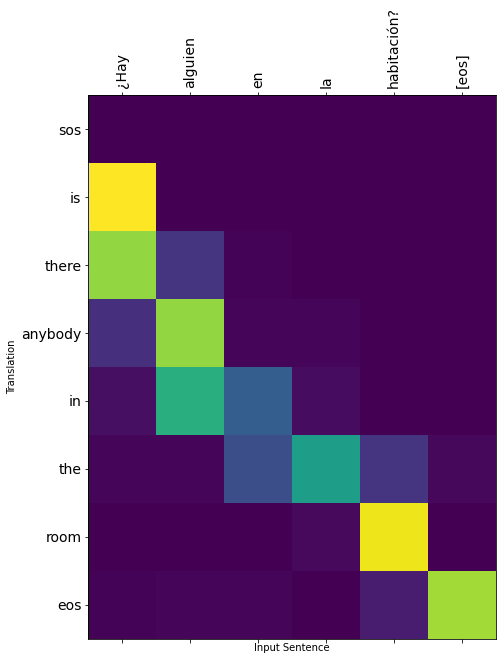

In [ ]:
i = np.random.randint(0, 60000)
print(i)
dec, sentence, attn = decode(spa_fwd[i])
print('Sentence    :',spa_fwd[i])
print('Translation :',eng_train[i])
print('\n')
print('Predicted Translation:', dec)

predicted_sentence = dec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attn, cmap='viridis')

fontdict = {'fontsize': 14}

ax.set_xticklabels(['']+ sentence.split() , fontdict=fontdict, rotation=90)
ax.set_yticklabels(['']+predicted_sentence.split(), fontdict=fontdict)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('Input Sentence')
ax.set_ylabel('Translation')
plt.show()

In [ ]:
#Checking some translations from validtion dataset
i = np.random.randint(1,10000)
# i = 2350
for j in range(50):
  print('sentence   :', i)
  print('orignal  :', eng_val[i])
  dec, sentence, attn = decode(spa_val_fwd[i])
  print('translation  :', dec)
  i+=1
  print('\n')

sentence   : 2350
orignal  : [sos] I'm not blaming you. [eos]
translation  : sos im not bluffing eos


sentence   : 2351
orignal  : [sos] They were talking together like old pals. [eos]
translation  : sos we found as old boy eos


sentence   : 2352
orignal  : [sos] I'm not blaming anybody. [eos]
translation  : sos im not giving up eos


sentence   : 2353
orignal  : [sos] I don't want to wait until tomorrow. [eos]
translation  : sos i dont want to wait until tomorrow eos


sentence   : 2354
orignal  : [sos] I can buy two. [eos]
translation  : sos i can buy two eos


sentence   : 2355
orignal  : [sos] Please remain seated. [eos]
translation  : sos stay on please eos


sentence   : 2356
orignal  : [sos] You guys need new shoes. [eos]
translation  : sos you need red shoes eos


sentence   : 2357
orignal  : [sos] Patience is the key. [eos]
translation  : sos the if is the key eos


sentence   : 2358
orignal  : [sos] Have you told Tom why you can't help? [eos]
translation  : sos have you tol

**Observations**


This translation seems to capture the meaning of the orignal sentence.

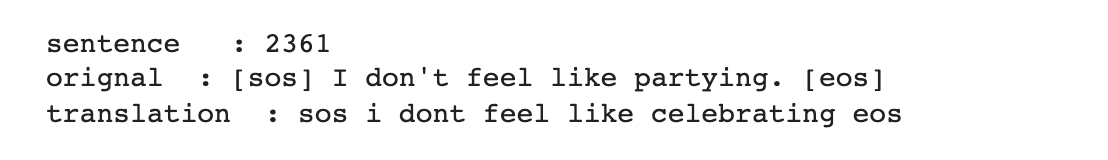

This is a funny one.

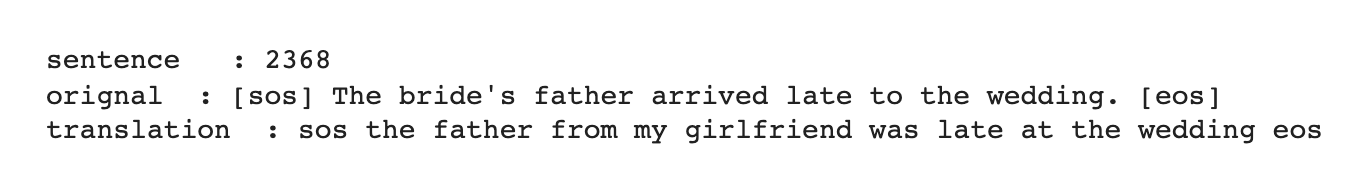

This one tries to make some sense but fails terribly.

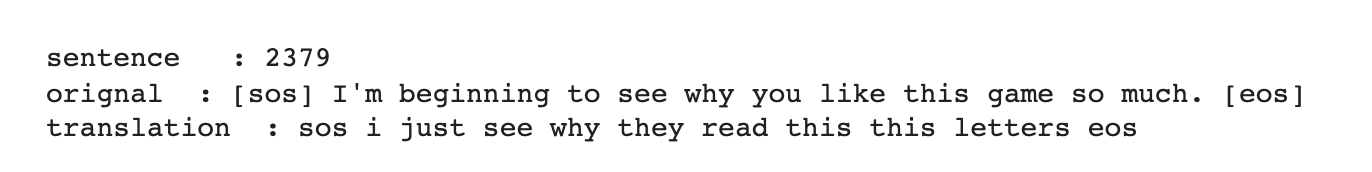

Our model seems to do a decent job on some of the translations while fails terribly on the others. The attention graph shows some pretty intersting visuals on how the model puts attention on different source words while translating target words.

**How to imporove futher**

1. We used only 60,000 sentences to train. Using more training data will surely help.
2. Our model uses single LSTM in both encoder and decoder. Using stacked LSTMs should also help.
3. We trained for 15 epochs. Training for more might help but we need to make sure that it doesnt overfit on training data.
4. We also need to calculate BLEU score so that we can quantify how good/bad our model is doing.

### References

1. https://www.youtube.com/watch?v=XXtpJxZBa2c&list=PLoROMvodv4rOhcuXMZkNm7j3fVwBBY42z&index=8
2. https://www.tensorflow.org/text/tutorials/nmt_with_attention
3. https://arxiv.org/pdf/1409.0473.pdf
4. https://arxiv.org/pdf/1508.04025.pdf
5. https://towardsdatascience.com/implementing-neural-machine-translation-with-attention-using-tensorflow-fc9c6f26155f
6. http://www.manythings.org/anki/